# Lecture 13: Logistic Regression

## Goals of this lecture

- Understanding logistic regression
- Understanding why linear regression isn't ideal for classification
- Contrast linear and logistic regression

--- 
### Reading material

K. Murphy; Machine Learning: A probabilistic perspective; Chapter 8

## Problem: Classification

- Given a dataset ${\cal D} = \{(x^{(i)},y^{(i)})\}_{i=1}^N$
- Data $x^{(i)} \in \mathbb{R}^d$
- Annotation/Label is **categorical**: $y^{(i)} \in \{-1,1\}$ (binary for now)

### Question:

$$\text{Given new unseen data $x$ how to predict its label $y$?}$$

## Let's largely follow linear regression

- Let's find the parameters $w$ of a parametric linear model $w^Tx$ by solving linear regression
- Let's predict the label using the $\operatorname{sign}$ function:

$$\hat y = \operatorname{sign}(w^Tx)$$

### Example: 1D data

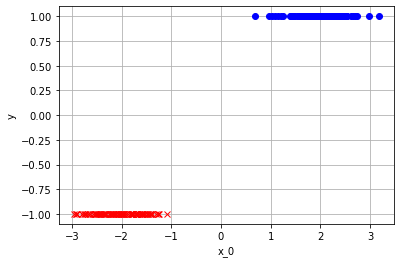

In [29]:
import torch
import matplotlib.pyplot as plt
x1 = torch.cat([0.5*torch.randn((100,))-2, 0.5*torch.randn((100,))+2],dim=0)
y = torch.cat([-torch.ones(100,1), torch.ones(100,1)],dim=0)
plt.plot(x1[0:100],y[0:100],'rx')
plt.plot(x1[100:200],y[100:200],'bo')
plt.xlabel('x_0')
plt.ylabel('y')
plt.grid(True)
plt.show()

### Train a classifier $w$ using linear regression

Objective:

$$\min_w \frac{1}{2} \sum_{(x^{(i)},y^{(i)})\in{\cal D}}\|x^{(i),T}w - y^{(i)}\|_2^2$$

Without the sum over each datapoint, i.e., by using $$X = \left[\begin{array}{ccc}\vdots&&\vdots\\x^{(1)} & \dots & x^{(|{\cal D|})}\\\vdots&&\vdots\\\end{array}\right] \quad\text{and}\quad y = \left[\begin{array}{c}y^{(1)}\\\vdots\\y^{|{\cal D}|}\end{array}\right]$$

$$\min_w \frac{1}{2}\|X^Tw - y\|_2^2$$

Analytical solution:

$$ w = (XX^T)^{-1}Xy$$

In [2]:
XT = torch.cat([x1.unsqueeze(0),torch.ones_like(x1).unsqueeze(0)],dim=0).t()
w = torch.inverse(XT.t()@XT)@XT.t()@y

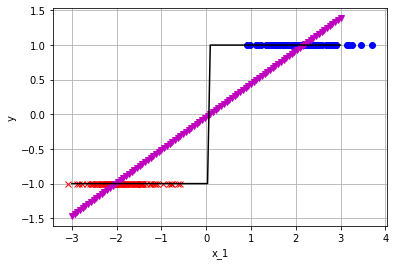

In [3]:
xaxis = torch.linspace(-3,3,100)
regressionoutput = torch.cat([xaxis.unsqueeze(0),torch.ones_like(xaxis).unsqueeze(0)],dim=0).t()@w
clfoutput = torch.sign(regressionoutput)
plt.plot(x1[0:100],y[0:100],'rx')
plt.plot(x1[100:200],y[100:200],'bo')
plt.plot(xaxis,regressionoutput,'-mv')
plt.plot(xaxis,clfoutput,'-k')
plt.xlabel('x_1')
plt.ylabel('y')
plt.grid(True)
plt.show()

Looks pretty good, doesn't it?

Let's add more data, which is already correctly classified to see what happens.

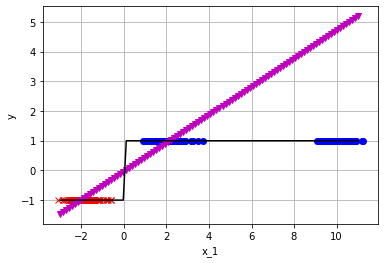

In [4]:
x1_new = torch.cat([x1, 0.5*torch.randn((100,))+10],dim=0)
y_new = torch.cat([y, torch.ones(100,1)],dim=0)
xaxis = torch.linspace(-3,11,100)
regressionoutput_old = torch.cat([xaxis.unsqueeze(0),torch.ones_like(xaxis).unsqueeze(0)],dim=0).t()@w
clfoutput_old = torch.sign(regressionoutput_old)
plt.plot(x1_new[0:100],y_new[0:100],'rx')
plt.plot(x1_new[100:],y_new[100:],'bo')
plt.plot(xaxis,regressionoutput_old,'-mv')
plt.plot(xaxis,clfoutput_old,'-k')
plt.xlabel('x_1')
plt.ylabel('y')
plt.grid(True)
plt.show()

Old classifier on new data works great. But what happens when we retrain the classifier on new and old data?

In [5]:
XT_new = torch.cat([x1_new.unsqueeze(0),torch.ones_like(x1_new).unsqueeze(0)],dim=0).t()
w_new = torch.inverse(XT_new.t()@XT_new)@XT_new.t()@y_new

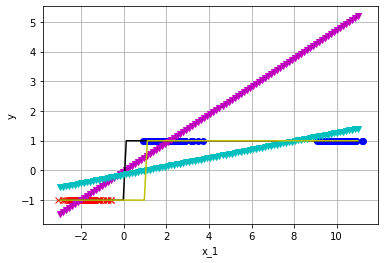

In [6]:
regressionoutput_new = torch.cat([xaxis.unsqueeze(0),torch.ones_like(xaxis).unsqueeze(0)],dim=0).t()@w_new
clfoutput_new = torch.sign(regressionoutput_new)
plt.plot(x1_new[0:100],y_new[0:100],'rx')
plt.plot(x1_new[100:],y_new[100:],'bo')
plt.plot(xaxis,regressionoutput_old,'-mv')
plt.plot(xaxis,clfoutput_old,'-k')
plt.plot(xaxis,regressionoutput_new,'-cv')
plt.plot(xaxis,clfoutput_new,'-y')
plt.xlabel('x_1')
plt.ylabel('y')
plt.grid(True)
plt.show()

Discuss:
- How come this new easy data screws up things?
- Shouldn't we get a better classifier if we train with more data?
- What is going wrong?

Recall the goal of linear regression:
- minimize the loss (vertical line connecting the data point with the regression line)
- linear regression is not ideal for classification because it doesn't consider the classification error but rather the regression error
- we need something else for classification

Instead of regressing a line $w^Tx$ let's regress the sigmoid function $$\frac{1}{1+\exp(-w^Tx)} \in [0,1]$$

How, i.e., what's the goal?

Goals:
- whenever an annotated datapoint $(x^{(i)}, y^{(i)})$ has a label $y^{(i)} = 1$ we want the sigmoid function to be as large as possible, i.e., as close as possible to 1
- whenever an annotated datapoint $(x^{(i)}, y^{(i)})$ has a label $y^{(i)} = -1$ we want the sigmoid function to be as small as possible, i.e., as close as possible to 0
- this last point can be formulated differently: whenever an annotated datapoint $(x^{(i)}, y^{(i)})$ has a label $y^{(i)} = -1$ we want one minus the sigmoid function to be as large as possible, i.e., as close as possible to 1: $$1 - \frac{1}{1+\exp(-w^Tx)} = \frac{1}{1+\exp(w^Tx)}$$

Taking into account $y^{(i)}\in\{-1,1\}$ we can combine both goals:
- our goal is to make the following as large as possible: $$\frac{1}{1+\exp(-y^{(i)}w^Tx^{(i)})}$$

This term actually expresses the probability that the random variable $Y$ representing the class label takes label $y$, i.e., $$p(Y=y|x) = \frac{1}{1+\exp(-yw^Tx)}$$

For notational convenience we instead often write $$p(y|x) = \frac{1}{1+\exp(-yw^Tx)}$$

How do we now combine all the annotations in our dataset ${\cal D} = \{(x^{(i)}, y^{(i)})\}$?
- summing?
- multiplying?

Multiplying: 
- we want to compute the probability that we observe the labels in this specific dataset ${\cal D}$
- we assume that every datapoint is independently drawn
- we assume that all datapoints are drawn from an the same (identical) distribution $p(y|x)$
- --> this is the i.i.d. assumption of data

$$p(y^{(1)}, \dots, y^{(|{\cal D}|)}|x^{(1)}, \dots, x^{(|{\cal D}|)}) = \prod_{(x^{(i)},y^{(i)})\in{\cal D}} p(y^{(i)}|x^{(i)})$$

Consequently, our goal (generally referred to as maximum likelihood) is $$\arg\max_w p(y^{(1)}, \dots, y^{(|{\cal D}|)}|x^{(1)}, \dots, x^{(|{\cal D}|)}) = $$

$$=\arg\max_w \prod_{(x^{(i)},y^{(i)})\in{\cal D}} p(y^{(i)}|x^{(i)}) = $$

Adding a monotonic transformation function like a log doesn't change the **maximizing argument**

$$= \arg\max_w \log\prod_{(x^{(i)},y^{(i)})\in{\cal D}} p(y^{(i)}|x^{(i)}) = $$

Negating just changes the direction of the function

$$ = \arg\min_w \sum_{(x^{(i)},y^{(i)})\in{\cal D}} -\log p(y^{(i)}|x^{(i)}) = $$

This is why people also call this **minimizing the negative log-likelihood (=maximizing the likelihood)**

$$ = \arg\min_w \sum_{(x^{(i)},y^{(i)})\in{\cal D}} \log (1 + \exp(-y^{(i)}w^Tx^{(i)}))$$

Now we have a new problem formulation (a new program which differs from linear regression). How can we optimize this?

How about computing the derivative, setting it to zero and solving for $w$:


$$ \frac{\partial}{\partial w} \sum_{(x^{(i)},y^{(i)})\in{\cal D}} \log (1 + \exp(-y^{(i)}w^Tx^{(i)})) = $$

$$ = \sum_{(x^{(i)},y^{(i)})\in{\cal D}} \frac{1}{1+\exp(-y^{(i)}w^Tx^{(i)})}\cdot \exp(-y^{(i)}w^Tx^{(i)}) \cdot (-y^{(i)}x^{(i)})$$

- Computing the derivative, setting it to zero and solving for $w$ doesn't work
- Numerical optimization is the only option here

Let's use our earlier data and give this a try: First version of our data

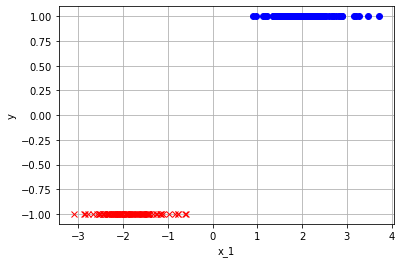

In [7]:
plt.plot(x1[0:100],y[0:100],'rx')
plt.plot(x1[100:200],y[100:200],'bo')
plt.xlabel('x_1')
plt.ylabel('y')
plt.grid(True)
plt.show()

tensor(0.0083)

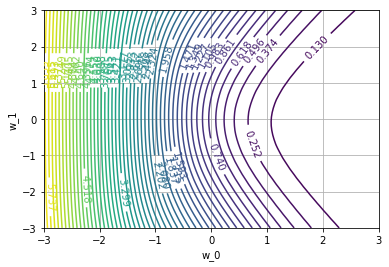

In [8]:
XT = torch.cat([x1.unsqueeze(0),torch.ones_like(x1).unsqueeze(0)],dim=0).t()
def logregfun(XT,y,w):
    return torch.mean(torch.log(1+torch.exp(-(XT@w)*y)),dim=0)
def logreggradfun(XT,y,w):
    tmp = torch.exp(-(XT@w)*y)
    return torch.mean((tmp/(1+tmp))*(-y*XT),dim=0)
[W0,W1] = torch.meshgrid(torch.linspace(-3,3,50),torch.linspace(-3,3,50))
W = torch.cat([W0.reshape(1,-1),W1.reshape(1,-1)],dim=0)
Z = logregfun(XT,y,W)
fig,ax = plt.subplots()
c = ax.contour(W0,W1,Z.view(W0.shape),torch.linspace(torch.min(Z),torch.max(Z),50))
ax.clabel(c,inline=1,fontsize=10)
ax.grid(True)
ax.set_xlabel('w_0')
ax.set_ylabel('w_1')
torch.min(Z)

Let's start from a random point $w_0$ and optimize one step at a time. Why?

In [9]:
w0 = torch.randn((2,1))

In [10]:
w = w0
alpha = 1.0
numIter = 200
funs = torch.zeros((numIter,1))
ws = torch.zeros((2,numIter+1))
ws[:,0] = w.view(-1)
for iter in range(numIter):
    f = logregfun(XT,y,w)
    g = logreggradfun(XT,y,w)
    w = w - alpha*g.view(-1,1)
    ws[:,iter+1] = w.view(-1)
    funs[iter] = f.item()

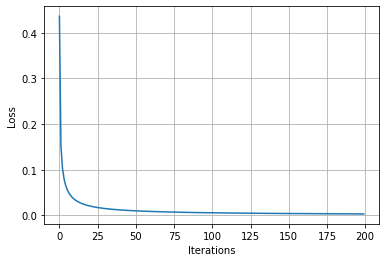

In [11]:
plt.plot(range(numIter),funs)
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

tensor([[ 3.7970],
        [-0.2801]])


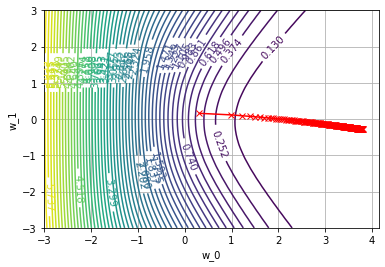

In [12]:
fig,ax = plt.subplots()
c = ax.contour(W0,W1,Z.view(W0.shape),torch.linspace(torch.min(Z),torch.max(Z),50))
ax.clabel(c,inline=1,fontsize=10)
ax.plot(ws[0,:],ws[1,:],'-rx')
ax.grid(True)
ax.set_xlabel('w_0')
ax.set_ylabel('w_1')
print(w)

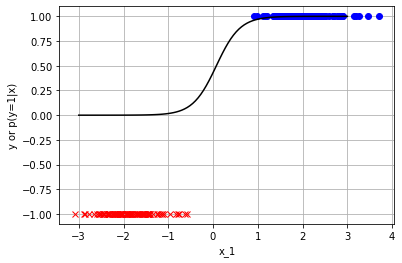

In [13]:
xaxis = torch.linspace(-3,3,100)
Xxaxis = torch.cat([xaxis.unsqueeze(0),torch.ones_like(xaxis).unsqueeze(0)],dim=0).t()
sigmoid = 1/(1+torch.exp(-Xxaxis@w))
plt.plot(x1[0:100],y[0:100],'rx')
plt.plot(x1[100:200],y[100:200],'bo')
plt.plot(xaxis,sigmoid,'-k')
plt.xlabel('x_1')
plt.ylabel('y or p(y=1|x)')
plt.grid(True)
plt.show()

Hey, this is PyTorch. Why do we implement the gradient manually?

In [14]:
w = w0.clone()
w.requires_grad = True
alpha = 1.0
numIter = 200
funs = torch.zeros((numIter,1))
ws = torch.zeros((2,numIter+1))
ws[:,0] = w.view(-1).detach()
for iter in range(numIter):
    w.grad = torch.zeros_like(w)
    f = logregfun(XT,y,w)
    f.backward()
    w.data = w.data - alpha*w.grad.view(-1,1).detach()
    ws[:,iter+1] = w.view(-1).detach()
    funs[iter] = f.item()

tensor([[ 3.7970],
        [-0.2801]], requires_grad=True)


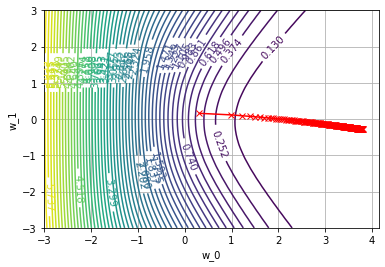

In [15]:
fig,ax = plt.subplots()
c = ax.contour(W0,W1,Z.view(W0.shape),torch.linspace(torch.min(Z),torch.max(Z),50))
ax.clabel(c,inline=1,fontsize=10)
ax.plot(ws[0,:],ws[1,:],'-rx')
ax.grid(True)
ax.set_xlabel('w_0')
ax.set_ylabel('w_1')
print(w)

We have all these optimizers too. Why do we implement gradient descent ourselves?

In [16]:
w = w0.clone()
w.requires_grad = True
alpha = 1.0
numIter = 200
funs = torch.zeros((numIter,1))
ws = torch.zeros((2,numIter+1))
ws[:,0] = w.view(-1).detach()
optimizer = torch.optim.SGD([w],lr=alpha,momentum=0,dampening=0,weight_decay=0)
for iter in range(numIter):
    optimizer.zero_grad()
    f = logregfun(XT,y,w)
    f.backward()
    optimizer.step()
    ws[:,iter+1] = w.view(-1).detach()
    funs[iter] = f.item()

tensor([[ 3.7970],
        [-0.2801]], requires_grad=True)


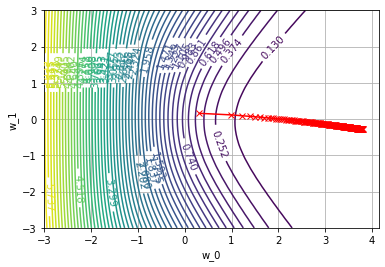

In [17]:
fig,ax = plt.subplots()
c = ax.contour(W0,W1,Z.view(W0.shape),torch.linspace(torch.min(Z),torch.max(Z),50))
ax.clabel(c,inline=1,fontsize=10)
ax.plot(ws[0,:],ws[1,:],'-rx')
ax.grid(True)
ax.set_xlabel('w_0')
ax.set_ylabel('w_1')
print(w)

What happens when we train on our modified data?

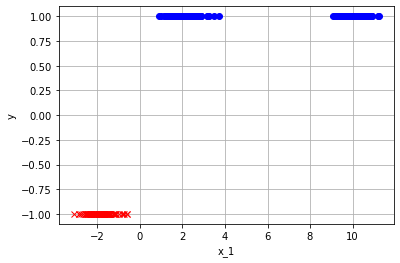

In [18]:
plt.plot(x1_new[0:100],y_new[0:100],'rx')
plt.plot(x1_new[100:],y_new[100:],'bo')
plt.xlabel('x_1')
plt.ylabel('y')
plt.grid(True)
plt.show()

tensor(0.0055)

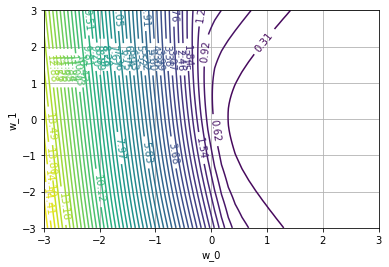

In [19]:
XT_new = torch.cat([x1_new.unsqueeze(0),torch.ones_like(x1_new).unsqueeze(0)],dim=0).t()
Z = logregfun(XT_new,y_new,W)
fig,ax = plt.subplots()
c = ax.contour(W0,W1,Z.view(W0.shape),torch.linspace(torch.min(Z),torch.max(Z),50))
ax.clabel(c,inline=1,fontsize=10)
ax.grid(True)
ax.set_xlabel('w_0')
ax.set_ylabel('w_1')
torch.min(Z)

In [20]:
w = w0.clone()
w.requires_grad = True
alpha = 1.0
numIter = 200
funs = torch.zeros((numIter,1))
ws = torch.zeros((2,numIter+1))
ws[:,0] = w.view(-1).detach()
optimizer = torch.optim.SGD([w],lr=alpha,momentum=0,dampening=0,weight_decay=0)
for iter in range(numIter):
    optimizer.zero_grad()
    f = logregfun(XT_new,y_new,w)
    f.backward()
    optimizer.step()
    ws[:,iter+1] = w.view(-1).detach()
    funs[iter] = f.item()

tensor([[ 3.5077],
        [-0.2225]], requires_grad=True)


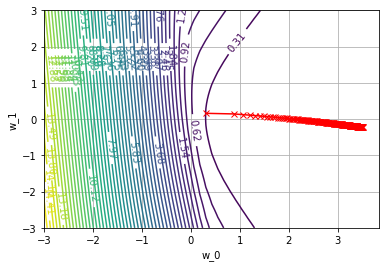

In [21]:
fig,ax = plt.subplots()
c = ax.contour(W0,W1,Z.view(W0.shape),torch.linspace(torch.min(Z),torch.max(Z),50))
ax.clabel(c,inline=1,fontsize=10)
ax.plot(ws[0,:],ws[1,:],'-rx')
ax.grid(True)
ax.set_xlabel('w_0')
ax.set_ylabel('w_1')
print(w)

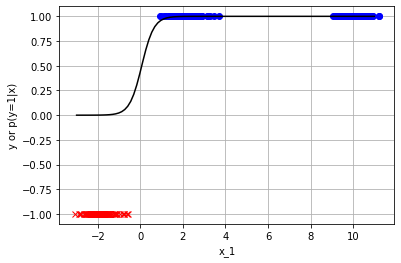

In [22]:
xaxis = torch.linspace(-3,11,100)
Xxaxis = torch.cat([xaxis.unsqueeze(0),torch.ones_like(xaxis).unsqueeze(0)],dim=0).t()
sigmoid = 1/(1+torch.exp(-Xxaxis@w.detach()))
plt.plot(x1_new[0:100],y_new[0:100],'rx')
plt.plot(x1_new[100:],y_new[100:],'bo')
plt.plot(xaxis,sigmoid,'-k')
plt.xlabel('x_1')
plt.ylabel('y or p(y=1|x)')
plt.grid(True)
plt.show()

Nice, this makes much more sense now.

Can we avoid that the objective is optimized at $w_0 = \infty$?

Use ```weight_decay``` (**$\ell_2$ regularizer**)

In [23]:
def logregfun_regularized(XT,y,w,C):
    return torch.mean(torch.log(1+torch.exp(-(XT@w)*y)),dim=0) + C/2*torch.norm(w,p=2,dim=0)**2

tensor(0.0055)

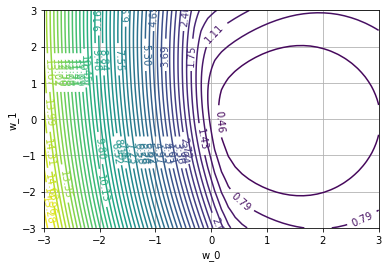

In [24]:
Z_reg = logregfun_regularized(XT_new,y_new,W,0.1)
fig,ax = plt.subplots()
c = ax.contour(W0,W1,Z_reg.view(W0.shape),torch.linspace(torch.min(Z_reg),torch.max(Z_reg),50))
ax.clabel(c,inline=1,fontsize=10)
ax.grid(True)
ax.set_xlabel('w_0')
ax.set_ylabel('w_1')
torch.min(Z)

In [25]:
w = w0.clone()
w.requires_grad = True
alpha = 1.0
numIter = 2000
funs = torch.zeros((numIter,1))
ws = torch.zeros((2,numIter+1))
ws[:,0] = w.view(-1).detach()
for iter in range(numIter):
    w.grad = torch.zeros_like(w)
    f = logregfun_regularized(XT,y,w,0.1)
    f.backward()
    w.data = w.data - alpha*w.grad.view(-1,1).detach()
    ws[:,iter+1] = w.view(-1).detach()
    funs[iter] = f.item()

tensor(0.0055)

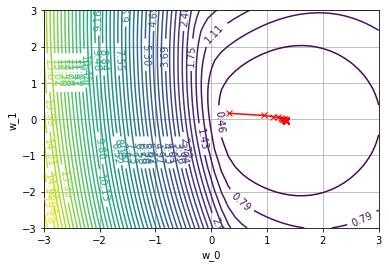

In [26]:
Z_reg = logregfun_regularized(XT_new,y_new,W,0.1)
fig,ax = plt.subplots()
c = ax.contour(W0,W1,Z_reg.view(W0.shape),torch.linspace(torch.min(Z_reg),torch.max(Z_reg),50))
ax.clabel(c,inline=1,fontsize=10)
ax.plot(ws[0,:],ws[1,:],'-rx')
ax.grid(True)
ax.set_xlabel('w_0')
ax.set_ylabel('w_1')
torch.min(Z)

How about with SGD optimizer?

In [27]:
w = w0.clone()
w.requires_grad = True
alpha = 1.0
numIter = 2000
funs = torch.zeros((numIter,1))
ws = torch.zeros((2,numIter+1))
ws[:,0] = w.view(-1).detach()
optimizer = torch.optim.SGD([w],lr=alpha,momentum=0,dampening=0,weight_decay=0.1)
for iter in range(numIter):
    optimizer.zero_grad()
    f = logregfun(XT_new,y_new,w)
    f.backward()
    optimizer.step()
    ws[:,iter+1] = w.view(-1).detach()
    funs[iter] = f.item()

tensor(0.0055)

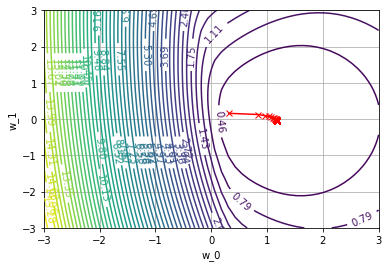

In [28]:
Z_reg = logregfun_regularized(XT_new,y_new,W,0.1)
fig,ax = plt.subplots()
c = ax.contour(W0,W1,Z_reg.view(W0.shape),torch.linspace(torch.min(Z_reg),torch.max(Z_reg),50))
ax.clabel(c,inline=1,fontsize=10)
ax.plot(ws[0,:],ws[1,:],'-rx')
ax.grid(True)
ax.set_xlabel('w_0')
ax.set_ylabel('w_1')
torch.min(Z)